# Zillow Project

## Goal:

* To find the key drivers of property value for single family properties and attempt to predict their future values.

## Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

from env import get_db_url
import os
import wrangle as w

## Acquire:

* Data acquired from MySQL Codeup Server
* Dataframe contained 52,442 Rows and 10 Columns before Cleaning.
* Each Row represents a single family home that has been sold some time in 2017.
* Each Column represents the specifics of the home, how many rooms, bathrooms, square footage, etc.

## Prepare:

### Prepare Actions

* Renamed Columns:

    * 'fips': 'county', 'bedroomcnt': 'bedrooms', 'garagecarcnt': 'garage_fits', 'bathroomcnt': 'bathrooms', 'garagetotalsqft': 'garage_area', 'calculatedfinishedsquarefeet': 'finished_area', 'lotsizesquarefeet': 'lot_area', 'taxvaluedollarcnt': 'home_value'



* Filled Null Values:

    * garage data had alot of null values; updated to '0'
        - further investigation showed that 'LA' County did not have the data for garages.
        - 'Orange' and 'Ventura' counties had garage data.



* Dropped the Rest of the Nulls:

    * 'yearbuilt', 'finished_area', 'lot_area', and 'home_value' had minimal null values( < .1% of data ).



* Changed County Values: 

    * 6037: 'LA', 6059: 'Orange', 6111: 'Ventura'



* Dropped Outliers for bedrooms:

    * Dropped homes with more than 8  and less than 1 bedrooms.



* Encoded County:

    * Encoded for modeling.



* Split data into Train, Validate, and Test (56/24/20), Target was 'home_value'



* Dropped 'transactiondate':

    * Was used to pull dataset from MySql to ensure we were looking at the right data.

| Feature | Definition |
|--------|-----------|
|Bedrooms| Number of Bedrooms|
|Bathrooms| Number of Bathrooms|
|Finished Area| Usable Square Footage of Home|
|Home Value| Price of Home|
|Year Built| Year house was built|
|Lot Area| Square Footage of the entire property lot|
|County| County location of home|
|Garage Fits| Number of Cars that Fit in Garage|
|Garage Area| Square Footage of the Garage|
|Transaction Date| Last time the house was sold in 2017|


In [2]:
# Acquiring and Prepping Data
df = w.get_zillow()
df = w.prep_zillow(df)

## Explore

### A brief look at the data

In [3]:
df.head()

,bedrooms,bathrooms,finished_area,home_value,yearbuilt,lot_area,county,garage_fits,garage_area
0,4,3.5,3100.0,1023282.0,1998,4506.0,Orange,2,633.0
1,2,1.0,1465.0,464000.0,1967,12647.0,Ventura,1,0.0
2,3,2.0,1243.0,564778.0,1962,8432.0,Orange,2,440.0
3,4,3.0,2376.0,145143.0,1970,13038.0,LA,0,0.0
4,4,3.0,2962.0,773303.0,1950,63000.0,LA,0,0.0


### A summary of the data

In [4]:
w.check_columns(df)



,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
6,county,3,"[Orange, Ventura, LA]",0,0.0,object
0,bedrooms,8,"[4, 2, 3, 6, 5, 1, 7, 8]",0,0.0,int64
7,garage_fits,12,"[2, 1, 0, 3, 5, 4, 7, 6, 8, 9, 13, 14]",0,0.0,int64
1,bathrooms,17,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 1.5, ...",0,0.0,float64
4,yearbuilt,133,"[1998, 1967, 1962, 1970, 1950, 1922, 1999, 198...",0,0.0,int64
8,garage_area,808,"[633.0, 0.0, 440.0, 420.0, 447.0, 485.0, 446.0...",0,0.0,float64
2,finished_area,4404,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0...",0,0.0,float64
5,lot_area,13874,"[4506.0, 12647.0, 8432.0, 13038.0, 63000.0, 42...",0,0.0,float64
3,home_value,37615,"[1023282.0, 464000.0, 564778.0, 145143.0, 7733...",0,0.0,float64


In [5]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,50841.0,3.304911,0.907431,1.0,3.0,3.0,4.0,8.0
bathrooms,50841.0,2.280758,0.949481,1.0,2.0,2.0,3.0,10.0
finished_area,50841.0,1891.458606,893.010819,152.0,1274.0,1657.0,2286.0,11020.0
home_value,50841.0,481543.801046,434316.463331,37431.0,197341.0,372917.0,609150.0,3076800.0
yearbuilt,50841.0,1963.433961,22.705263,1878.0,1950.0,1961.0,1979.0,2016.0
lot_area,50841.0,11065.639740,87341.829496,236.0,5595.0,6830.0,8716.0,6971010.0
garage_fits,50841.0,0.678389,0.975550,0.0,0.0,0.0,2.0,14.0
garage_area,50841.0,172.487343,251.199144,0.0,0.0,0.0,433.0,4251.0


### Data Split

In [6]:
train, validate, test = w.split_data(df)

Train: 0.5599811176019355
Validate: 0.2400031470663441
Test: 0.20001573533172046


### How do bedrooms affect home_value?


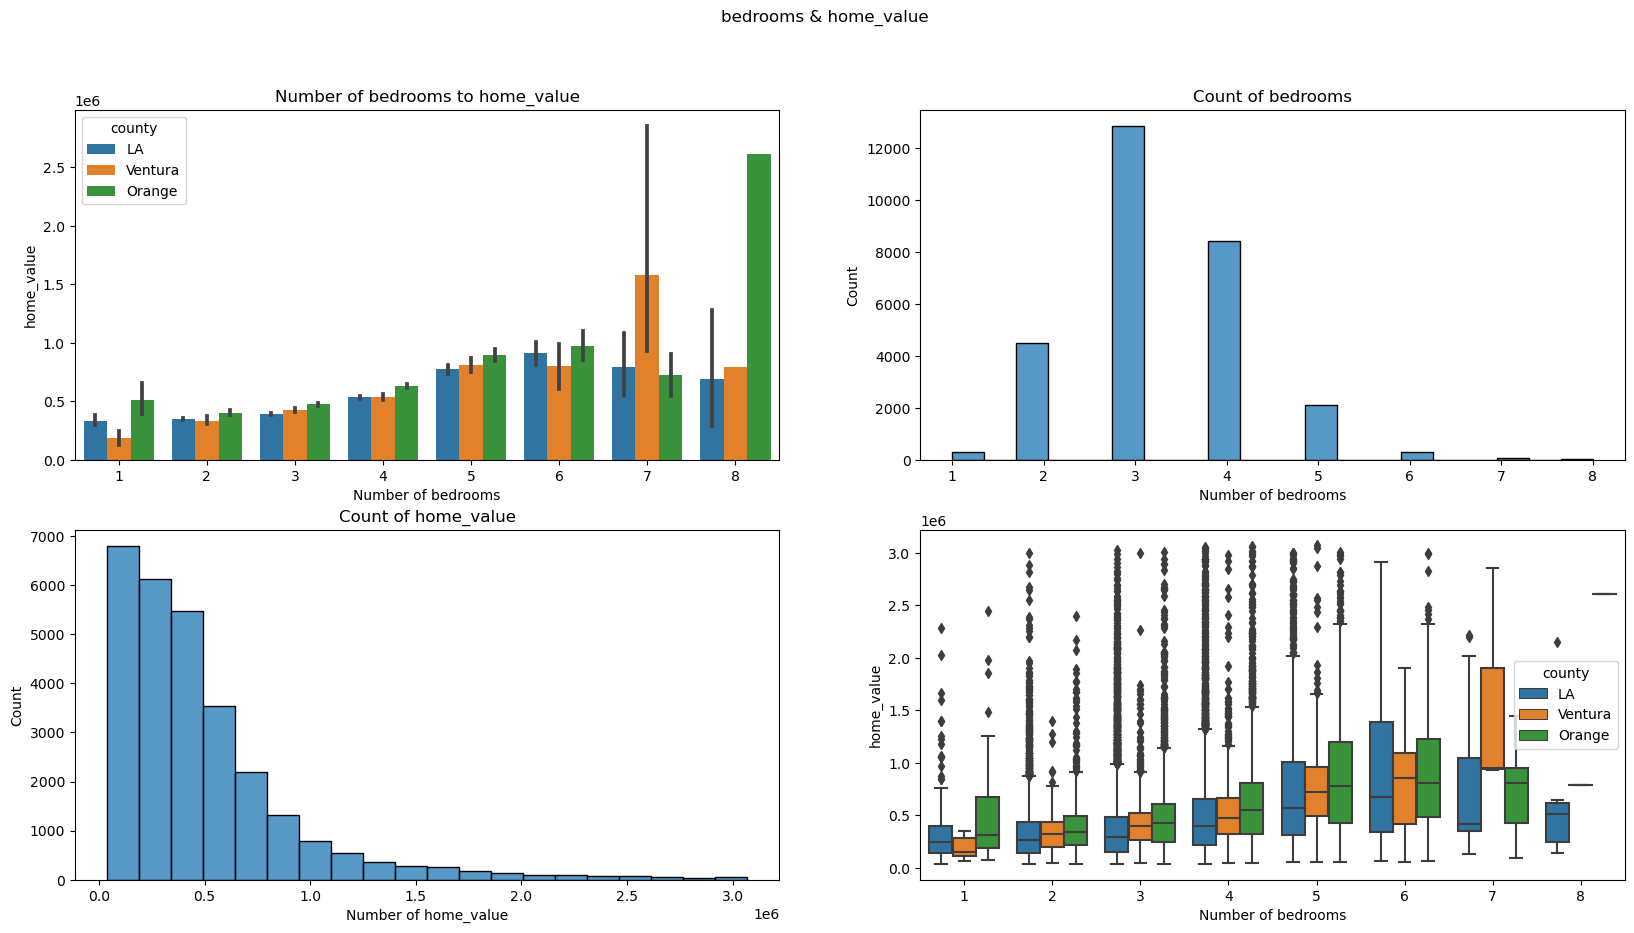

In [7]:
w.catcont_four_graphs(train, 'bedrooms', 'home_value', 'county')

ADD Stats Test

### How do bathrooms affect home_value?

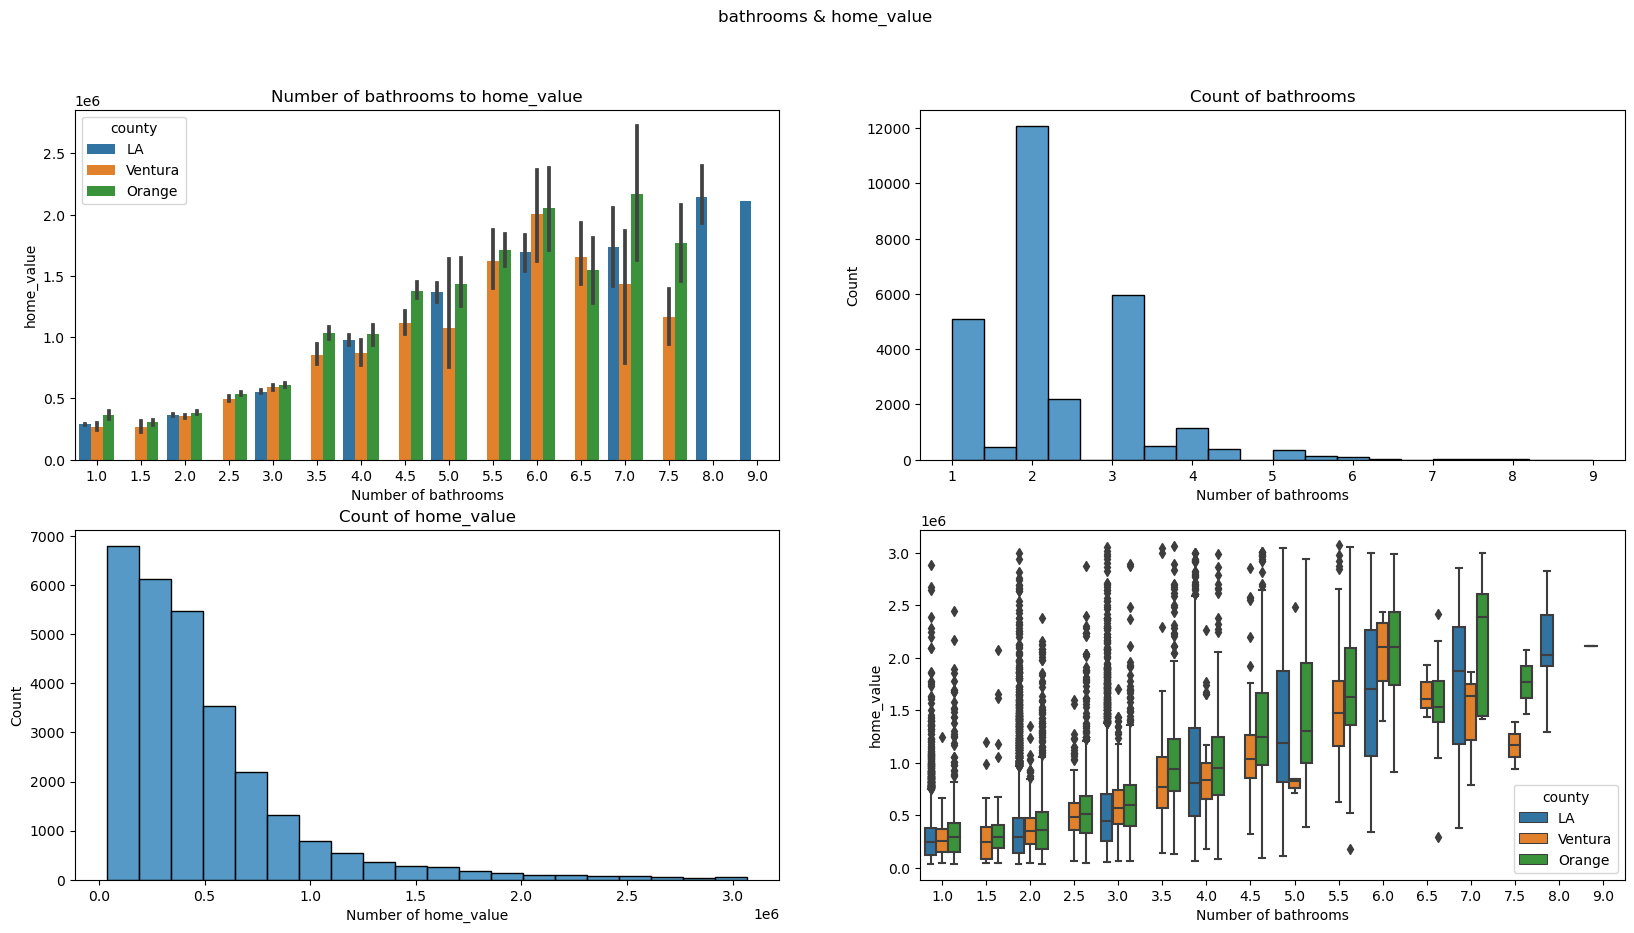

In [8]:
w.catcont_four_graphs(train, 'bathrooms', 'home_value', 'county')

ADD Stats Test

### How doe finished area affect home_value?

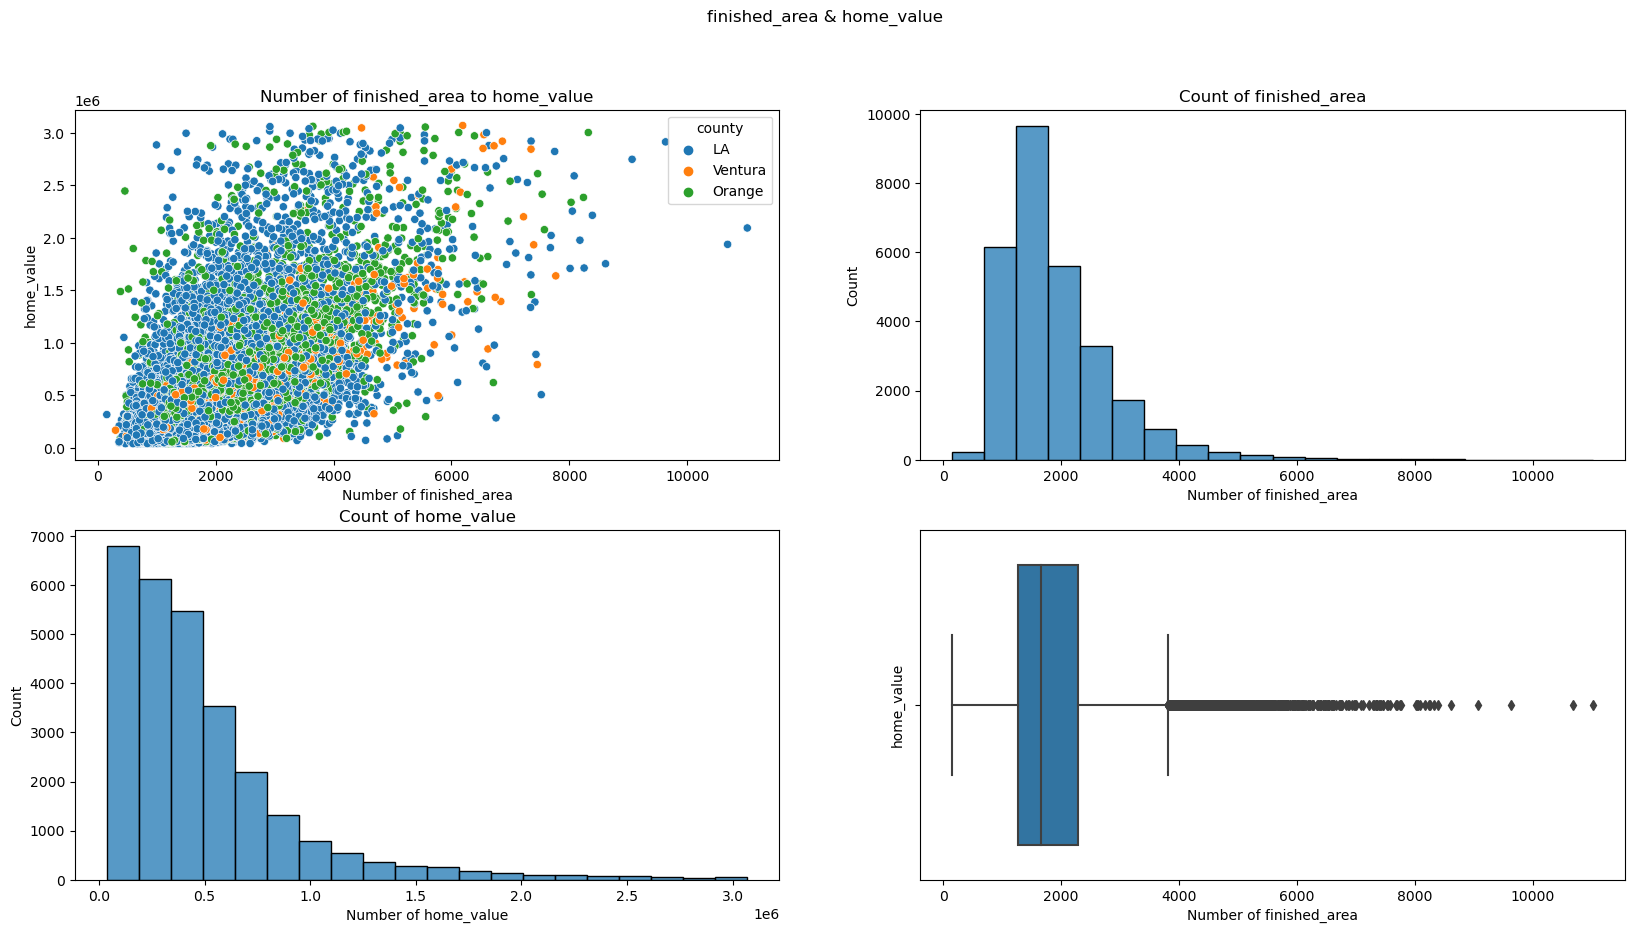

In [9]:
w.contcont_four_graphs(train, 'finished_area', 'home_value', 'county')

ADD Stats Test

## Exploration Summary

Discuss Quickly about the Similarities and Diffs and put in heatmap

## Modeling

Split the X and Y variables, then made a copy, and scaled them

In [10]:
X_train, y_train, X_validate, y_validate, X_test, y_test = w.model_prep_zillow(train, validate, test, 'home_value')

In [11]:
X_train_scaled, X_valid_scaled, X_test_scaled = w.model_prep_zillow_scaled(X_train, X_validate, X_test)

In [12]:
baseline= y_train.mean()
baseline

483350.5956445381

In [13]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([483350.59564454, 483350.59564454, 483350.59564454, 483350.59564454,
       483350.59564454])

In [14]:
rmse, r2 = w.metrics_reg(y_train, baseline_array)
rmse, r2

(436299.2747071282, 0.0)

In [15]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.0


### Model 1: Multiple Regression

What feature is the best from RFE?

In [16]:
X_train_rfe, X_val_rfe = w.get_best_feat_rfe(X_train_scaled, X_valid_scaled, y_train, 1)

selected top feature: ['finished_area']


Model ran with 3 Features, 'bedrooms', 'bathrooms', and finished_area.

In [17]:
rmse, r2 = w.get_lr(X_train_scaled, X_valid_scaled, y_train, y_validate, 3)
rmse, r2

selected top feature: ['bedrooms' 'bathrooms' 'finished_area']


(338239.85815456643, 0.3764368451033524)

In [18]:
metrics_df.loc[1] = ['Line Reg', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437


### Model 2: LassoLars

In [19]:
rmse, r2 = w.get_lasso(X_train_scaled, X_valid_scaled, y_train, y_validate)
rmse, r2

(338239.8374247037, 0.3764369215365573)

In [20]:
#add to my metrics df
metrics_df.loc[2] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437


### Model 3: Polynomial Regression 2 Degree

In [21]:
rmse, r2 = w.get_poly(X_train_scaled, X_valid_scaled, y_train,y_validate, 2)
rmse, r2

(335612.3315603228, 0.38608718573431466)

In [22]:
#add to my metrics df
metrics_df.loc[3] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437
3,poly_2,335612.331560,0.386087


### Model 4: Polynomial Regression 3 Degree

In [23]:
rmse, r2 = w.get_poly(X_train_scaled, X_valid_scaled, y_train,y_validate, 3)
rmse, r2

(335040.36504114565, 0.38817792156117237)

In [24]:
#add to my metrics df
metrics_df.loc[4] = ['poly_3', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,436299.274707,0.000000
1,Line Reg,338239.858155,0.376437
2,lars,338239.837425,0.376437
3,poly_2,335612.331560,0.386087
4,poly_3,335040.365041,0.388178


Overall Results Between the models & Graphs

### Model 4: Test Results

## Conclusion

### Summary

### Recommendations